In [1]:
import numpy as np
import pandas as pd
from itertools import product

In [2]:
sim_dfs = {}
simulators = ["cloudsim", "networkcloudsim", "dissectcf", "opendc", "simgrid"]
for simulator in simulators:
    df = pd.read_csv(f"energy/{simulator}.energy")
    df = df[df["time"] <= 300]
    sim_dfs[simulator] = df
    

# Overview

## Mean per powermodel - simulator combination

In [3]:
powermodel_overview = {}

for simulator, sim_df in sim_dfs.items():
    sim_df["rel_error_total_abs"] = sim_df["rel_error_total"].abs()
    df = sim_df.dropna(subset=["powermodel", "workload", "rel_error_total_abs"])
    df = df[df["time"] == df["time"].max()]
    grouped = df.groupby(["powermodel", "workload"])["rel_error_total_abs"].mean().round(2).unstack("workload")
    powermodel_overview[simulator] = grouped

overview_df = pd.concat(powermodel_overview, axis=1)
overview_df[("Mean", "")] = overview_df.mean(axis=1).round(2)
mean_row = overview_df.mean(axis=0).round(2)
mean_row.name = "Mean"
overview_df = pd.concat([overview_df, pd.DataFrame([mean_row])])

overview_df

cloudsim networkcloudsim dissectcf  opendc simgrid                    \
workload    trace   trace-network       swf parquet  simple simple-with-comms   
cubic        0.45            0.47       NaN    0.41     NaN               NaN   
linear       0.79            0.80      0.71    0.41    0.42              0.42   
sqrt         0.90            0.90       NaN    0.37     NaN               NaN   
square       0.61            0.62       NaN    0.41     NaN               NaN   
constant      NaN             NaN      0.44    0.14     NaN               NaN   
Mean         0.69            0.70      0.57    0.35    0.42              0.42   

          Mean  
workload        
cubic     0.44  
linear    0.59  
sqrt      0.72  
square    0.55  
constant  0.29  
Mean      0.52

In [4]:
best_combos = {
    "cloudsim": "cubic",
    "networkcloudsim": "cubic",
    "dissectcf":  "constant",
    "opendc": "constant",
    "simgrid": "linear"
}

# Check significant differences

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import shapiro
from scipy.stats import mannwhitneyu
from scipy.stats import kruskal
from functools import reduce

In [6]:
def check_if_diff(df, var_name):
    df = df[["joules_total", var_name]]
    
    # Check for normality
    if len(df[var_name].unique()) < 2:
        return

    if len(df[var_name].unique()) < 4:
        for var in df[var_name].unique():
            subset = df[df[var_name] == var]["joules_total"].dropna()

            plt.figure(figsize=(2, 2))
            stats.probplot(subset, dist="norm", plot=plt)
            plt.title(f"Q–Q Plot for {var_name}: {var}")
            plt.xlabel("Theoretical Quantiles")
            plt.ylabel("Sample Quantiles")
            plt.grid(True)
            plt.tight_layout()
            plt.show()

    for var in df[var_name].unique():
        subset = df[df[var_name] == var]["joules_total"].dropna()
        stat, p = shapiro(subset)
        print(f"{var}: p = {p:.4f} {'(normal)' if p > 0.05 else '(not normal)'}")
        assert p < 0.05
    
    if len(df[var_name].unique()) == 2:
        A = df[df[var_name] == df[var_name].unique()[0]]["joules_total"]
        B = df[df[var_name] == df[var_name].unique()[1]]["joules_total"]

        u_stat, p_val = mannwhitneyu(A, B, alternative='two-sided')
        print(f"p-value Mann-Whitney U test: {p_val:.4f}")
    else:
        ABCs = [df[df[var_name] == x]["joules_total"] for x in df[var_name].unique()]

        h_stat, p_val = kruskal(*ABCs)
        print(f"p-value Kruskal–Wallis test = {p_val:.4f}")
    
    if p_val > 0.05:
        print("Not significantly different!")
    else:
        print("Significantly Different!")



## Simgrid with or without communication

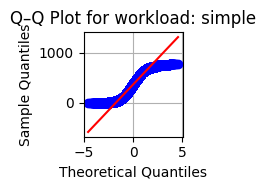

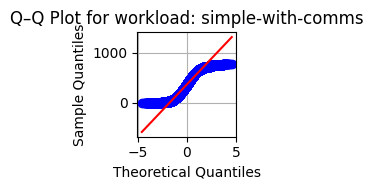

/home/meret/.pyenv/versions/3.10.4/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 288960.
  res = hypotest_fun_out(*samples, **kwds)


simple: p = 0.0000 (not normal)
simple-with-comms: p = 0.0000 (not normal)
p-value Mann-Whitney U test: 1.0000
Not significantly different!


In [7]:
check_if_diff(sim_dfs["simgrid"], "workload")

The p-value is greater than 0.05, which means that we can confidently assume that there is no significant difference between the simulated energy difference with or without communication being simulated.
We therefore get rid of the simple-with-comms measurements.

In [8]:
simgrid_df = sim_dfs["simgrid"]
sim_dfs["simgrid"] = simgrid_df[simgrid_df["workload"] == "simple"]

## Create Super DF

In [9]:
dfs = []
for simulator, sim_df in sim_dfs.items():
    df = sim_df
    df["simulator"] = simulator
    group_cols = [col for col in df.columns if col != "run" and col != "joules_total"]
    df_avg = df.groupby(group_cols)["joules_total"].mean().reset_index()
    
    dfs.append(df_avg)

super_df = reduce(
    lambda left, right: pd.merge(left, right, on=list(df_avg.columns), how="outer", suffixes=('', '_dup')),
    dfs
)

super_df

/tmp/ipykernel_56605/2478401710.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["simulator"] = simulator


,time,joules,time_diff,host_power,joules_correct,joules_total_correct,error_total,error,rel_error_total,rel_error,...,powermodel,workload,test_system,scenario,users,repetition,rel_error_total_abs,simulator,joules_total,policy_dup
0,5.0,2.378730,5.0,4.857042,24.252698,24.252698,12.323698,12.323698,0.508137,0.508137,...,linear,simple,trainticket,A,100,27,0.508137,simgrid,11.929000,NaN
1,5.0,2.378730,5.0,4.867932,24.252004,24.252004,12.320804,12.320804,0.508032,0.508032,...,linear,simple,trainticket,B,1000,13,0.508032,simgrid,11.931200,NaN
2,5.0,2.378740,5.0,5.200397,25.818503,25.818503,13.861003,13.861003,0.536863,0.536863,...,linear,simple,trainticket,A,100,3,0.536863,simgrid,11.957500,NaN
3,5.0,2.378740,5.0,3.242176,16.237581,16.237581,4.306681,4.306681,0.265229,0.265229,...,linear,simple,trainticket,A,1000,29,0.265229,simgrid,11.930900,NaN
4,5.0,2.378740,5.0,3.002478,15.002733,15.002733,3.086833,3.086833,0.205751,0.205751,...,linear,simple,sockshop,B,100,17,0.205751,simgrid,11.915900,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45621,300.0,15.779087,5.0,5.070895,23.399288,1362.750871,-964.664401,-23.937972,-0.707880,-1.023021,...,linear,swf,trainticket,B,100,28,0.707880,dissectcf,2327.415272,NaN
45622,300.0,15.779087,5.0,6.319752,34.057651,1465.367341,-862.047930,-13.279609,-0.588281,-0.389916,...,linear,swf,trainticket,B,1000,8,0.588281,dissectcf,2327.415272,NaN
45623,300.0,15.779087,5.0,4.585710,25.004627,1462.116231,-865.299041,-22.332633,-0.591813,-0.893140,...,linear,swf,trainticket,B,1000,12,0.591813,dissectcf,2327.415272,NaN
45624,300.0,15.779087,5.0,5.444233,29.443945,1464.594262,-862.821009,-17.893315,-0.589119,-0.607708,...,linear,swf,trainticket,B,1000,13,0.589119,dissectcf,2327.415272,NaN


## Between all simulators

In [10]:
check_if_diff(super_df, "simulator")


simgrid: p = 0.0000 (not normal)
cloudsim: p = 0.0000 (not normal)
networkcloudsim: p = 0.0000 (not normal)
opendc: p = 0.0000 (not normal)
dissectcf: p = 0.0000 (not normal)
p-value Kruskal–Wallis test = 0.0000
Significantly Different!


/home/meret/.pyenv/versions/3.10.4/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 15287.
  res = hypotest_fun_out(*samples, **kwds)
/home/meret/.pyenv/versions/3.10.4/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 15187.
  res = hypotest_fun_out(*samples, **kwds)
/home/meret/.pyenv/versions/3.10.4/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 9520.
  res = hypotest_fun_out(*samples, **kwds)


### Between CloudSim and NetworkCloudSim

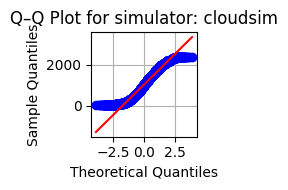

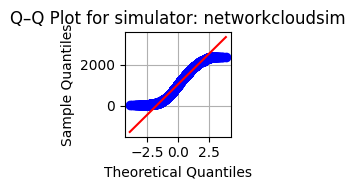

cloudsim: p = 0.0000 (not normal)
networkcloudsim: p = 0.0000 (not normal)
p-value Mann-Whitney U test: 0.0491
Significantly Different!


/home/meret/.pyenv/versions/3.10.4/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 15287.
  res = hypotest_fun_out(*samples, **kwds)
/home/meret/.pyenv/versions/3.10.4/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 15187.
  res = hypotest_fun_out(*samples, **kwds)


In [11]:
check_if_diff(super_df[(super_df["simulator"] == "cloudsim") | (super_df["simulator"] == "networkcloudsim")], "simulator")

## Powermodels

### Between powermodels

LINEAR
simgrid: p = 0.0000 (not normal)
networkcloudsim: p = 0.0000 (not normal)
cloudsim: p = 0.0000 (not normal)
opendc: p = 0.0000 (not normal)
dissectcf: p = 0.0000 (not normal)
p-value Kruskal–Wallis test = 0.0000
Significantly Different!
CUBIC


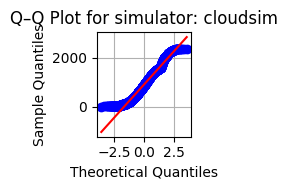

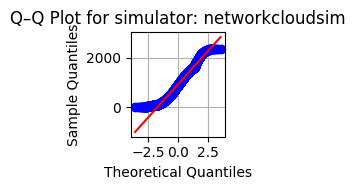

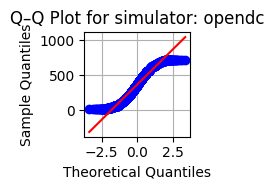

cloudsim: p = 0.0000 (not normal)
networkcloudsim: p = 0.0000 (not normal)
opendc: p = 0.0000 (not normal)
p-value Kruskal–Wallis test = 0.0000
Significantly Different!
SQUARE


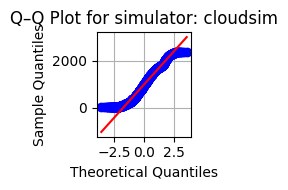

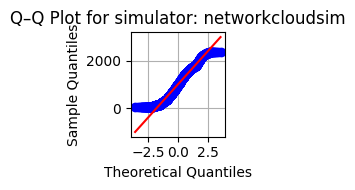

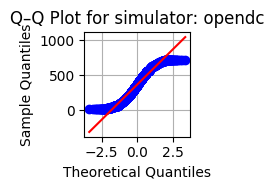

cloudsim: p = 0.0000 (not normal)
networkcloudsim: p = 0.0000 (not normal)
opendc: p = 0.0000 (not normal)
p-value Kruskal–Wallis test = 0.0000
Significantly Different!
SQRT


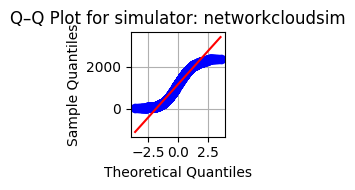

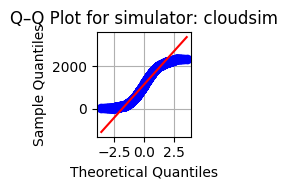

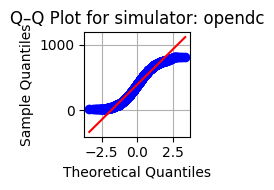

networkcloudsim: p = 0.0000 (not normal)
cloudsim: p = 0.0000 (not normal)
opendc: p = 0.0000 (not normal)
p-value Kruskal–Wallis test = 0.0000
Significantly Different!
CONSTANT


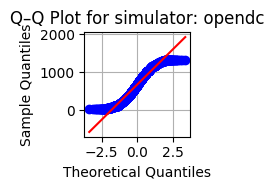

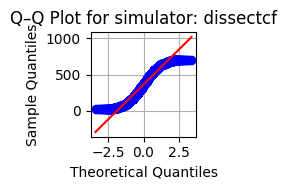

opendc: p = 0.0000 (not normal)
dissectcf: p = 0.0000 (not normal)
p-value Mann-Whitney U test: 0.0000
Significantly Different!


In [12]:
for powermodel in super_df["powermodel"].unique():
    print(powermodel.upper())
    check_if_diff(super_df[super_df["powermodel"] == powermodel], "simulator")

### Between powermodels within simulators

CLOUDSIM
cubic: p = 0.0000 (not normal)
square: p = 0.0000 (not normal)
linear: p = 0.0000 (not normal)
sqrt: p = 0.0000 (not normal)
p-value Kruskal–Wallis test = 0.0000
Significantly Different!
NETWORKCLOUDSIM
cubic: p = 0.0000 (not normal)
square: p = 0.0000 (not normal)
linear: p = 0.0000 (not normal)
sqrt: p = 0.0000 (not normal)
p-value Kruskal–Wallis test = 0.0000
Significantly Different!
DISSECTCF


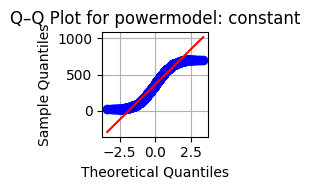

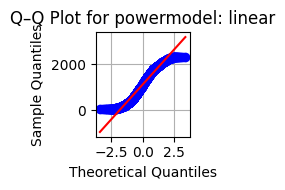

constant: p = 0.0000 (not normal)
linear: p = 0.0000 (not normal)
p-value Mann-Whitney U test: 0.0000
Significantly Different!
OPENDC
cubic: p = 0.0000 (not normal)
square: p = 0.0000 (not normal)
linear: p = 0.0000 (not normal)
sqrt: p = 0.0000 (not normal)
constant: p = 0.0000 (not normal)
p-value Kruskal–Wallis test = 0.0000
Significantly Different!
SIMGRID


In [13]:
for simulator in simulators:
    print(simulator.upper())
    check_if_diff(super_df[super_df["simulator"] == simulator], "powermodel")

# Results

In [14]:
fs = 13

In [15]:
linestyles = {
    "constant": "solid",
    "ground truth": "solid",
    "linear": "dotted",
    "cubic": "dashed",
    "sqrt": "dashdot",
    "square": (3, 1, 1.5, 1, 1.5, 1)
}

In [16]:
colors = {
    "ground truth": "black",
    "opendc": "#377eb8",
    "dissectcf": "#984ea3",
    "cloudsim": "#4daf4a",
    "networkcloudsim": "#f781bf",
    "simgrid": "#ff7f00",
}

## Best selection

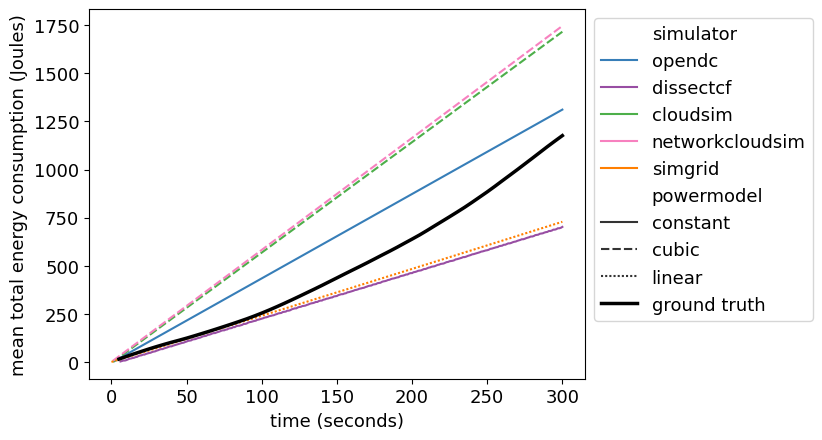

In [17]:
dfs = []
for simulator in simulators:
    sim_df = sim_dfs[simulator]
    df = sim_df[(sim_df["powermodel"] == best_combos[simulator])] 
    df = df.groupby(["powermodel", "time"])["joules_total"].mean().reset_index()
    df["simulator"] = simulator
    df["joules_total"] = pd.to_numeric(df["joules_total"], errors="coerce")
    df["time"] = pd.to_numeric(df["time"], errors="coerce")

    dfs.append(df)


merged_df = reduce(
    lambda left, right: pd.merge(left, right, on=["powermodel", "time", "simulator", "joules_total"], how="outer", suffixes=('', '_dup')),
    dfs
)


sns.lineplot(
    data=merged_df,
    x="time",
    y="joules_total",
    hue="simulator",
    style="powermodel",
    dashes=True,
    palette=colors
)

# Add ground truth
df = sim_dfs["cloudsim"][["time", "joules_total_correct"]].dropna(subset=["joules_total_correct"]).groupby(["time"]).mean().reset_index()

plt.plot(
    df["time"],
    df["joules_total_correct"],
    color="black",
    linewidth=2.5,
    label="ground truth"
)

plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)
plt.xlabel("time (seconds)", fontsize=fs)
plt.ylabel("mean total energy consumption (Joules)", fontsize=fs)
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', fontsize=fs)


## All over time

In [18]:
def graph_over_time(ax, system, scenario, users):
    dfs = []
    for simulator in simulators:
        sim_df = sim_dfs[simulator]
        df = sim_df[(sim_df["test_system"] == system) &
                    (sim_df["scenario"] == scenario) &
                    (sim_df["users"] == users)] 
        df = df.groupby(["powermodel", "time"])["joules_total"].mean().reset_index()
        df["simulator"] = simulator
        df["joules_total"] = pd.to_numeric(df["joules_total"], errors="coerce")
        df["time"] = pd.to_numeric(df["time"], errors="coerce")
        
        dfs.append(df)

        
    merged_df = reduce(
        lambda left, right: pd.merge(left, right, on=["powermodel", "time", "simulator", "joules_total"], how="outer", suffixes=('', '_dup')),
        dfs
    )

    
    sns.lineplot(
        data=merged_df,
        x="time",
        y="joules_total",
        hue="simulator",
        style="powermodel",
        ax=ax,
        dashes=True,    
        palette=colors
    )

    df = sim_dfs["cloudsim"][["time", "joules_total_correct"]].dropna(subset=["joules_total_correct"]).groupby(["time"]).mean().reset_index()
    
    ax.plot(
        df["time"],
        df["joules_total_correct"],
        color="black",
        linewidth=2.5,
        label="ground truth"
    )

    ax.set_xlabel("time (seconds)")
    ax.set_ylabel("mean total energy consumption (Joules)")
    ax.legend()


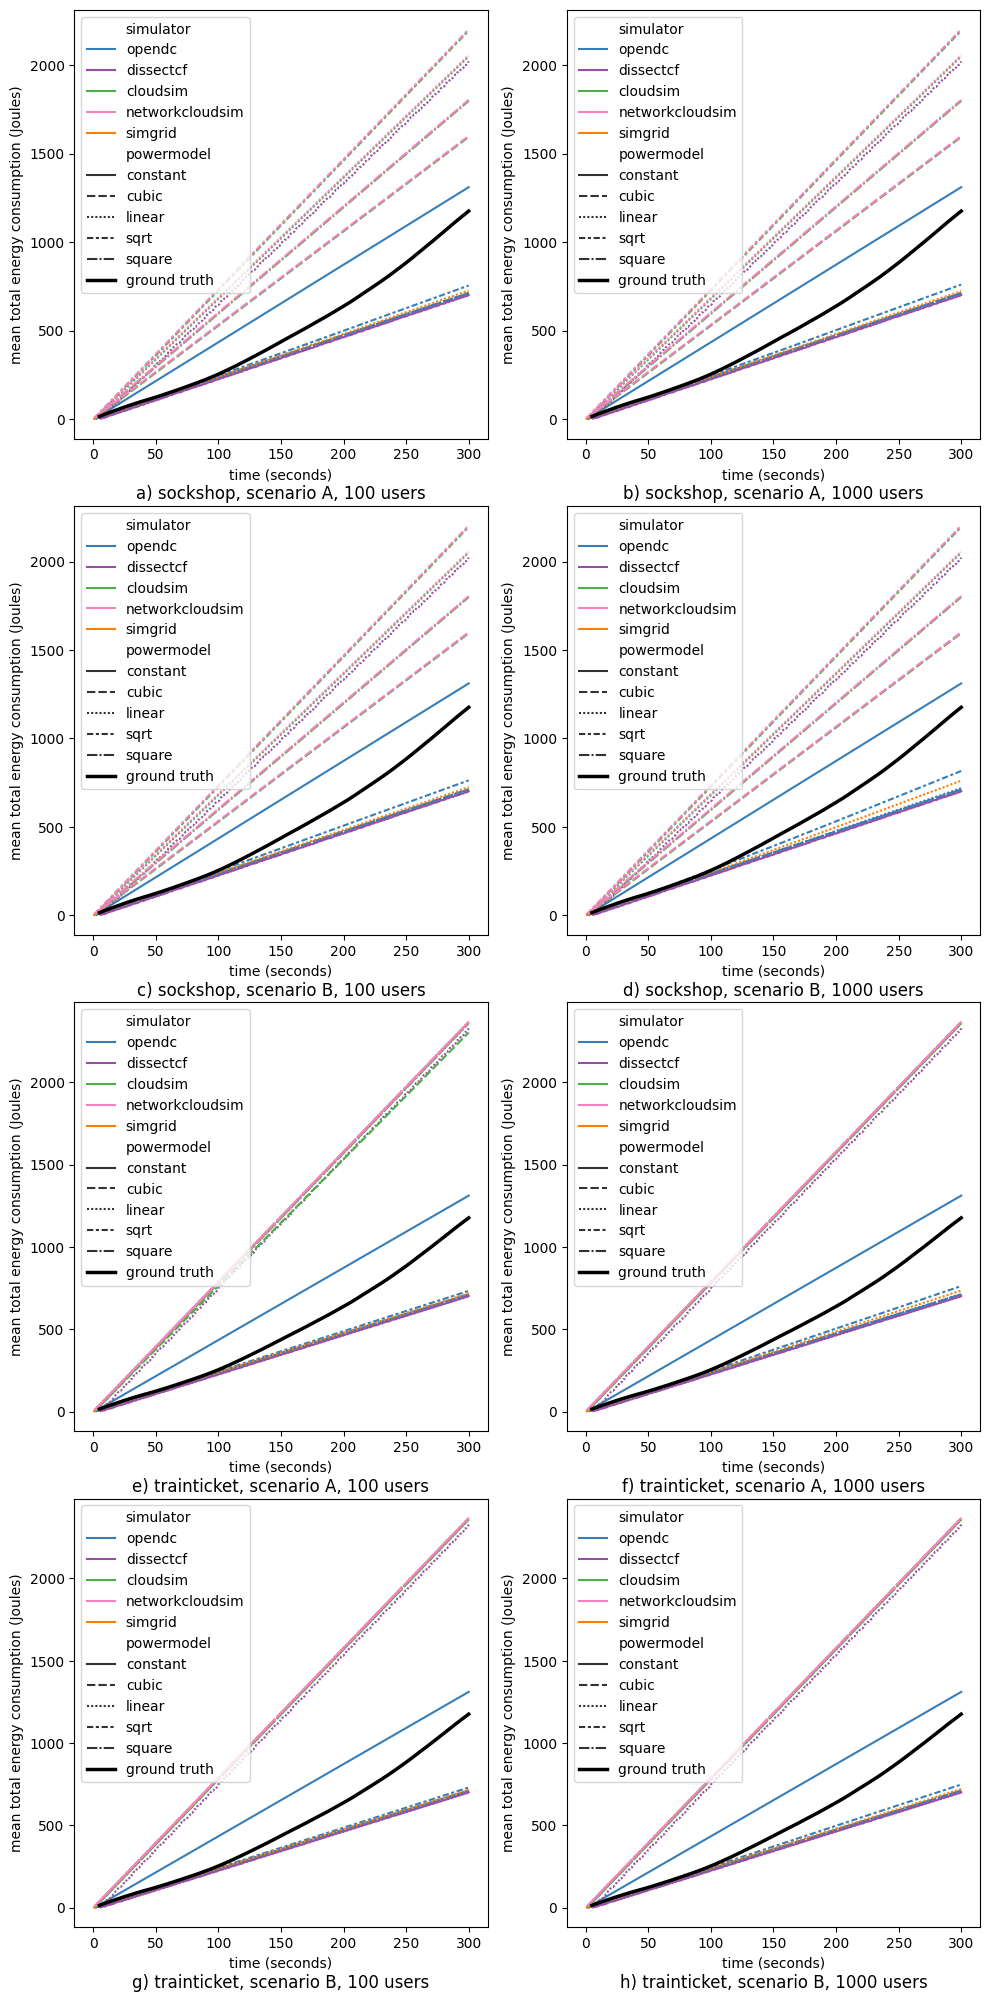

In [19]:
from itertools import product

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(10, 20), sharex=False, sharey=False)
axes = axes.flatten()

combinations = list(product(["sockshop", "trainticket"], ["A", "B"], [100, 1000]))
for i, (ax, (system, scenario, users)) in enumerate(zip(axes, combinations)):
    graph_over_time(ax, system, scenario, users)
    
    ax.text(
        0.5, -0.13, f"{'abcdefgh'[i]}) {system}, scenario {scenario}, {users} users",  # centered below
        transform=ax.transAxes,
        ha='center',
        va='center',
        fontsize='large'
    )

plt.tight_layout()
plt.show()
            

## CDF totals

Text(0, 0.5, 'CDF')

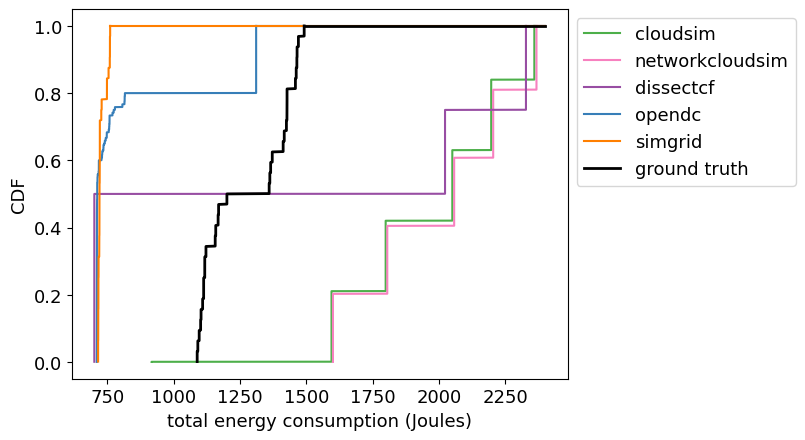

In [20]:
for simulator in simulators:
    sim_df = sim_dfs[simulator]
    totals = sim_df[sim_df["time"].round() == 300]["joules_total"].values
    sorted_totals = np.sort(totals)
    cdf = np.arange(1, len(sorted_totals) + 1) / len(sorted_totals)
    plt.plot(sorted_totals, cdf, label=simulator, color=colors[simulator])
    plt.plot(
        [sorted_totals[-1], 2400],
        [cdf[-1], cdf[-1]],
        color=colors[simulator]
    )

totals = sim_df[sim_df["time"].round() == 300]["joules_total_correct"].values
sorted_totals = np.sort(totals)
cdf = np.arange(1, len(sorted_totals) + 1) / len(sorted_totals)
plt.plot(sorted_totals, cdf, label="ground truth", color="black", linewidth=2)
plt.plot(
    [sorted_totals[-1], 2400],
    [cdf[-1], cdf[-1]],
    color="black",
    linewidth=2
)

plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', fontsize=fs)
plt.xlabel("total energy consumption (Joules)", fontsize=fs)
plt.ylabel("CDF", fontsize=fs)

In [21]:
def cdf_system(ax, system):
    cdf_data = []
    for simulator in simulators:
        powermodel = best_combos[simulator]
        sim_df = sim_dfs[simulator]
        totals = sim_df[(sim_df["time"].round() == 300) & (sim_df["powermodel"] == powermodel) & (sim_df["test_system"] == system)]["joules_total"].values # (sim_df["test_system"] == system)]

        sorted_totals = np.sort(totals)
        cdf = np.arange(1, len(sorted_totals) + 1) / len(sorted_totals)
        ax.plot(sorted_totals, cdf, label=f"{simulator} - {powermodel}", color=colors[simulator], linestyle=linestyles[powermodel])
        ax.plot(
            [sorted_totals[-1], 2400],
            [cdf[-1], cdf[-1]],
            color=colors[simulator]
        )
        
    
    totals = sim_df[(sim_df["time"].round() == 300) & (sim_df["test_system"] == system)]["joules_total_correct"].values
    sorted_totals = np.sort(totals)
    cdf = np.arange(1, len(sorted_totals) + 1) / len(sorted_totals)
    ax.plot(sorted_totals, cdf, label="ground truth", color="black", linewidth=2)
    ax.plot(
        [sorted_totals[-1], 2400],
        [cdf[-1], cdf[-1]],
        color="black",
        linewidth=2
    )



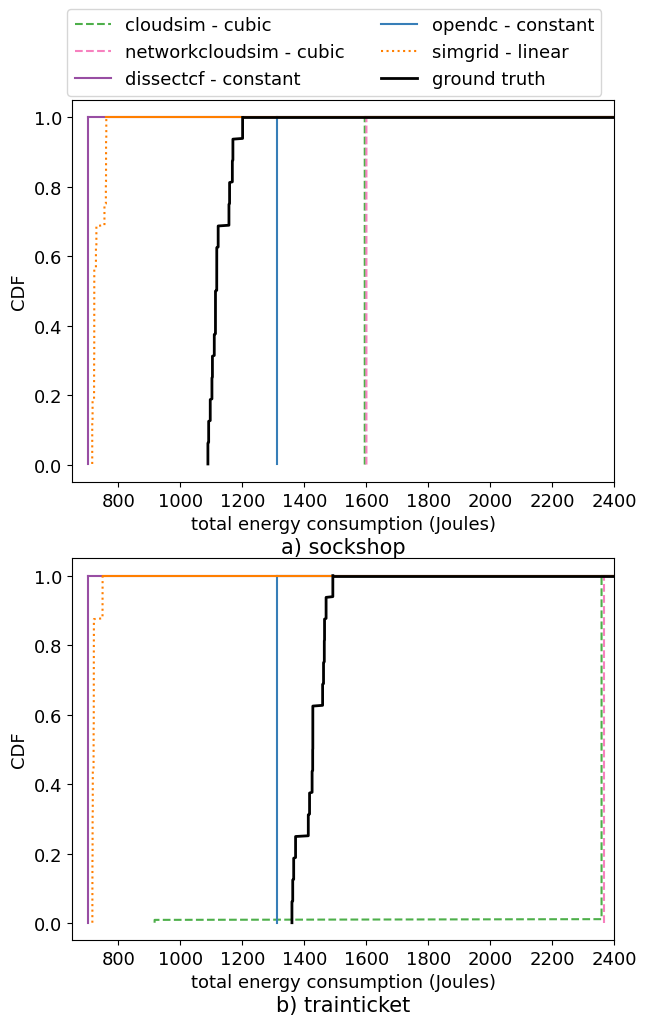

In [22]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(7, 10), sharex=False, sharey=False)
axes = axes.flatten()

combinations = ["sockshop", "trainticket"]
for i, (ax, system) in enumerate(zip(axes, combinations)):
    cdf_system(ax, system)
    
    ax.text(
        0.5, -0.17,f"{'abcdefgh'[i]}) {system}",
        transform=ax.transAxes,
        ha='center',
        va='center',
        fontsize=fs+2
    )

    ax.tick_params(labelsize=fs)
    ax.set_xlabel("total energy consumption (Joules)", fontsize=fs)
    ax.set_ylabel("CDF", fontsize=fs) 
    ax.set_xlim(650, 2400)

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles, labels,
    loc='upper center',
    bbox_to_anchor=(0.5, 1.05),
    fontsize=fs,
    ncol=2
)
plt.subplots_adjust(top=0.95)
# fig.tight_layout()

## Difference between CloudSim and NetworkCloudSim

In [23]:
cloudsim = sim_dfs["cloudsim"][["joules_total", "time"]].groupby(["time"])["joules_total"].mean().reset_index().rename(columns={"joules_total": "joules_total_cloudsim"})
networkcloudsim = sim_dfs["networkcloudsim"][["joules_total", "time"]].groupby(["time"])["joules_total"].mean().reset_index().rename(columns={"joules_total": "joules_total_networkcloudsim"})
merged = pd.merge(cloudsim, networkcloudsim, on="time")
merged["joules_total_diff"] = merged["joules_total_networkcloudsim"] - merged["joules_total_cloudsim"]
merged["joules_total_diff"].describe()



count    300.000000
mean      13.769703
std        4.042284
min        6.806884
25%       10.285550
50%       13.764215
75%       17.253434
max       20.735602
Name: joules_total_diff, dtype: float64

In [24]:
list(sim_dfs.values())[0].columns

Index(['time', 'joules_total', 'joules', 'time_diff', 'host_power',
       'joules_correct', 'joules_total_correct', 'error_total', 'error',
       'rel_error_total', 'rel_error', 'policy', 'powermodel', 'run',
       'workload', 'test_system', 'scenario', 'users', 'repetition',
       'rel_error_total_abs', 'simulator'],
      dtype='object')

# Determinacy

In [30]:
for simulator in simulators:
    sim_df = sim_dfs[simulator]
    df = sim_df

    group_cols = ["time", "scenario", "repetition", "users"]

    df["watt"] = df["joules"]/df["time_diff"]

    std_df = df.groupby(group_cols)["watt"].std().reset_index(name="std")

    print(simulator + " stdev: mean=" + str(std_df["std"].mean()))



cloudsim stdev: mean=0.09447424912870069
networkcloudsim stdev: mean=0.08822786492183718
dissectcf stdev: mean=0.48362530219488303
opendc stdev: mean=0.15973152047968375
simgrid stdev: mean=3.4124647384170898e-06


/tmp/ipykernel_56605/2695516428.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["watt"] = df["joules"]/df["time_diff"]
